,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,435971.4371,296617655379.0833,519916.5112,-0.9066,0.0900,0.0733,0.0100
par,Passive Aggressive Regressor,439757.5457,335596577238.0274,578197.6338,-0.8624,0.0913,0.0730,0.0067
huber,Huber Regressor,447302.6931,364337597244.9414,603208.2102,-0.9407,0.0937,0.0727,0.0133
omp,Orthogonal Matching Pursuit,454832.0057,310493803703.2498,543946.8724,-0.8688,0.0940,0.0749,0.0067
xgboost,Extreme Gradient Boosting,605304.6771,584802347690.6666,764562.0417,-2.0863,0.1292,0.0963,0.1067
dt,Decision Tree Regressor,635684.8519,665486026420.0741,809061.6088,-2.4701,0.1389,0.1016,0.0100
gbr,Gradient Boosting Regressor,661647.6820,642838944679.1383,801155.4569,-2.4663,0.1364,0.1059,0.0333
lr,Linear Regression,677510.7917,5815303553024.0000,1657254.4271,-20.8110,0.1465,0.1006,0.0067
et,Extra Trees Regressor,696149.0526,705897277075.1053,833275.3332,-2.5042,0.1393,0.1087,0.0533
rf,Random Forest Regressor,714790.1089,736311159326.9517,849726.6146,-2.6875,0.1426,0.1118,0.0700


<class 'sklearn.linear_model._bayes.BayesianRidge'>


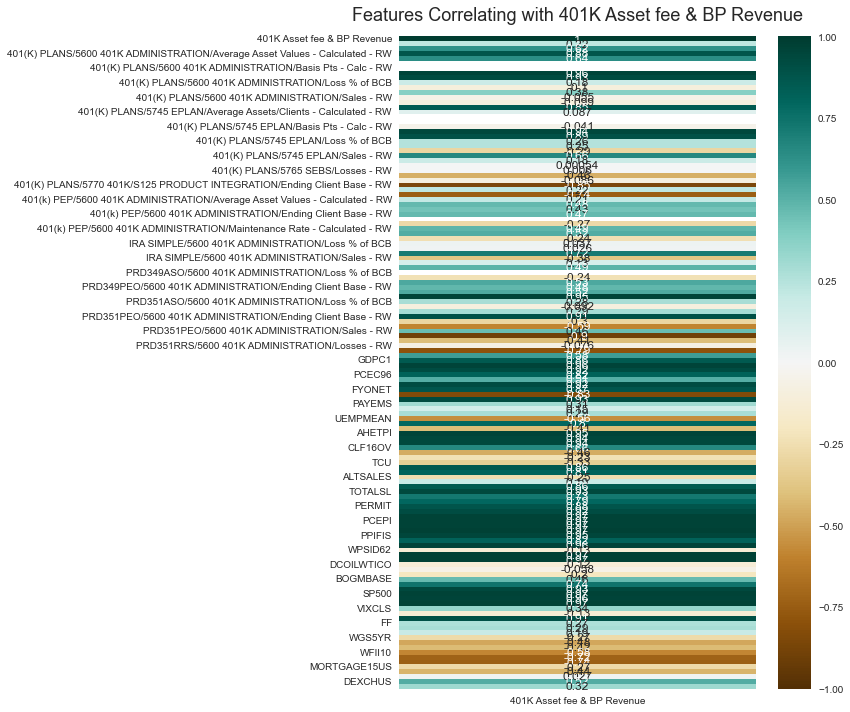

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
from pycaret.regression import *
import pmdarima as pm
from pmdarima.arima import ARIMA
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
#import import_ipynb
import data_loader as dl

warnings.filterwarnings("ignore")

In [ ]:
def run_auto_ml(train_df, test_df, target_col, feature_cols, normal_transform, ml_criteria):
    # Model Definitions
    s = setup(data = train_df,
              test_data = test_df,
              target = target_col,
              fold_strategy = 'timeseries',
              numeric_features = feature_cols,
              fold = 3,
              transform_target = normal_transform,
              feature_selection = True,
              feature_selection_threshold = 0.8,
              remove_multicollinearity = True,
              multicollinearity_threshold = 0.9,
              session_id = 123)
    best = compare_models(sort = ml_criteria)
    results = pull()
    model_results = results.Model.tolist()
    print(type(best))
    return best

def get_important_features(get_config, best):
    # Get list of features and their values
    features = pd.DataFrame({'Feature': get_config('X_train').columns,
                             'Variable Importance' : abs(best.coef_)}).sort_values(by='Variable Importance', ascending=False)
    features['Variable Importance'] = features['Variable Importance'].astype(float)

    # Here we want to get features with an absolute value variable importance score of 1 or greater
    features = features[features['Variable Importance'] >= 1]
    features = features.reset_index(drop=True)
    return features

def run_auto_arima(df, feature_cols, pred_start_dt, forecast_window):
    pred_df = pd.DataFrame()
    dti = pd.date_range(pred_start_dt, periods=forecast_window, freq="M")
    dti = dti + pd.offsets.MonthBegin(-1)
    pred_df['Calendar Date'] = dti

    for col in feature_cols:
        model = pm.auto_arima(df[col],
                              start_p=1,
                              start_q=1,
                              max_p=5,
                              max_q=5,
                              m=12,
                              start_P=0,
                              seasonal=True,
                              d=1,
                              D=1,
                              trace=True,
                              error_action='ignore',  # don't want to know if an order does not work
                              suppress_warnings=True,  # don't want convergence warnings
                              stepwise=True)  # set to stepwise

        # make future predictions
        pred_df[col] = model.predict(n_periods=forecast_window)
    return pred_df

def compute_apes_and_mapes(df, date_col, target_col, feature_cols):
    sort_cols = [date_col, target_col]
    ape_cols = []
    for col in feature_cols:
        ape_col = col+' - APE'
        df[ape_col] = ((df[target_col] - df[col]).abs())/df[target_col]
        sort_cols.append(col)
        sort_cols.append(ape_col)
        ape_cols.append(ape_col)
    df = df[sort_cols]
    non_ape_cols = list(set(sort_cols) - set(ape_cols))
    mape_df = df.groupby([True]*len(df)).mean(numeric_only=True)
    mape_df[non_ape_cols] = np.nan
    df = pd.concat([df,mape_df])
    return df

# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'

# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
#target_col = 'Payroll blended products'
#has_drivers = True
#target_col = 'W-2 Revenue'
#has_drivers = False
#target_col = 'Delivery Revenue'
#has_drivers = False
#target_col = 'ASO Allocation'
#has_drivers = False
#target_col = 'Other Processing Revenue'
#has_drivers = False
#target_col = 'SurePayroll.'
#has_drivers = True
#target_col = 'Total international'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
#target_col = '401K Fee Revenue'
#has_drivers = True
target_col = '401K Asset fee & BP Revenue'
has_drivers = True



ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [ml_col,uts_col,plan_col,fcst_col]
has_actuals = True
#has_drivers = False

# Get the full data frame and combine with drivers
all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_driver_data(train_start_dt, pred_end_dt, target_col)
    driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')
ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
print(corr_df)
#corr_df = corr_df[corr_df[target_col].abs() >= 0.75]
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

# run auto ml and get the most important features
best = run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

features = pd.DataFrame()
try:
    features = get_important_features(get_config, best)
    #feature_cols = features['Feature'].tolist()
except:
    #best_tree = compare_models(include=['br'], sort = ml_criteria)
    #features = get_important_features(get_config, best_tree)
    print('No default features available - will use the highest correlated columns')
    corr_df = corr_df.reset_index()
    feature_cols = corr_df['index'].tolist()
    feature_cols.remove(target_col)

corr_df = corr_df.reset_index()
feature_cols = corr_df['index'].tolist()
feature_cols.remove(target_col)

# Feature Importance Plot - This is the out of box pycaret plot
#plot_model(best, plot = 'feature')

if len(features.index) != 0:
    # plot the most important features
    fig = px.bar(features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance',
                 y='Feature',
                 orientation='h',
                 title='Feature Importance Plot')
    fig.show()

# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #
keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

In [2]:
# create the future predictions dataframe
if has_actuals:
    act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
    act_df = act_df[keeps]
    act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])
    pred_df = run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df.rename(columns={'Label':ml_col}, inplace=True)
    concat_df = pd.merge(pred_df,act_df, on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_plan_data(pred_start_dt, pred_end_dt)
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_forecast_data(pred_start_dt, pred_end_dt, forecast_type)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

    # run UTS 
    uts_df = comb_df[['Calendar Date', target_col]]
    uts_df = run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window)
    uts_df.rename(columns={target_col:uts_col}, inplace=True)
    concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')
    
    # combine all data together
    concat_df = pd.concat([comb_df,concat_df], axis=0)
    
    # show plot
    fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
    fig.show()
    
    # compute mape_df
    mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
    mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
    mape_df = compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
    mape_df.rename(index={True:'MAPE'}, inplace=True)
    #print(mape_df)
    data_dir = './'
    data_file = 'mapes.xlsx'
    mape_df.to_excel(data_dir+data_file, sheet_name=target_col[0:31])  


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=992.039, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=960.394, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=946.108, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=965.830, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=948.089, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=948.550, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.81 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=974.171, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=960.004, Time=0.22 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=947.732, Time=0.82 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total

OSError: Cannot save file into a non-existent directory: 'C:\Users\jgillespie\Desktop\Paychex'